#### Libraries and dependencies

In [2]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from copy import deepcopy
from numpy.fft import fft, ifft
from scipy.stats import zscore
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
output_dir = "E:/jerry/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)
probes = cache.get_probe_table() # type: ignore
valid_lfp = probes[probes['has_lfp_data']]
print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fraction of insertions with valid LFP:  0.9602209944751381


#### 1064644573

In [3]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore
probeA = session.get_lfp(1064735071) #VISam
probeB = session.get_lfp(1064735072) #VISpm
probeC = session.get_lfp(1064735073) #VISp
probeD = session.get_lfp(1064735075) #VISl
probeE = session.get_lfp(1064735076) #VISal
probeF = session.get_lfp(1064735077) #VISrl
chans = session.get_channels()

In [4]:
# getting the start and end of stim block 0
stim_pre = session.stimulus_presentations
stim = stim_pre[stim_pre['stimulus_name'].str.contains('Natural')]
stim = stim[stim['stimulus_block'] == 0]
stim_times = stim.start_time.values # all the start times
stim_ids = stim.index.values # all the stimulus ids
start = stim.iloc[0].start_time
end = stim.iloc[-1].end_time
master_time = np.arange(start, end, 1/1250) # start to end sliced by 0.8ms <- sampling rate of LFP

26.51665497698943
3627.411090114033


#### [Tutorial] Aligning LFP

In [40]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    #print(time_selection)
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [41]:
aligned_lfp = align_lfp(probeB, np.arange(-0.2, 0.2, 1/10), [stim_times[0]], [stim_ids[0]])

In [42]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

NameError: name 'lfp' is not defined

#### Filtering

In [5]:
lfpA_slice = probeA.sel(time=master_time, method='nearest')
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpD_slice = probeD.sel(time=master_time, method='nearest')
lfpE_slice = probeE.sel(time=master_time, method='nearest')
lfpF_slice = probeF.sel(time=master_time, method='nearest')
lfpA_copy = deepcopy(lfpA_slice)
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
lfpD_copy = deepcopy(lfpD_slice)
lfpE_copy = deepcopy(lfpE_slice)
lfpF_copy = deepcopy(lfpF_slice)

In [6]:
mask = np.array([60]) # channel 60
A_single = lfpA_copy[:,mask]
B_single = lfpB_copy[:,mask]
C_single = lfpC_copy[:,mask]
D_single = lfpD_copy[:,mask]
E_single = lfpE_copy[:,mask]
F_single = lfpF_copy[:,mask]

In [7]:
bands = np.zeros((4, 6, len(A_single))) # 4 bands, 6 channels, 400k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.hstack((A_single,B_single,C_single,D_single,E_single,F_single))
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    b,a = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='ba') # butterworth
    all_channels_ff = filtfilt(b,a,all_channels.T) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    all_channels_env_abs_z = zscore(all_channels_env_abs, axis=1)
    bands[i] = all_channels_env_abs_z
bands = np.reshape(bands,(4*6, len(A_single)))

#### Gaussian HMM for LFP

In [8]:
def plot(model, preds, num=3):
    means = model.means_
    vals = np.mean(means[preds], axis=1)
    plt.plot(vals[0:int(750*num/0.8)])
    start_time = 0
    for i in range(num):
        plt.axvspan(start_time/0.8, (start_time+250)/0.8, alpha=0.2, color='red') # stimulus
        start_time += 250
        plt.axvspan(start_time/0.8, (start_time+500)/0.8, alpha=0.2, color='gray') # gray
        start_time += 500

In [9]:
model = hmm.GaussianHMM(n_components=3, n_iter=100, verbose=True, tol=0.1)
model.fit(bands.T[0:100000]) # to speed up training
preds= model.predict(bands.T[0:100000])

         1 -3386904.97489184             +nan
         2 -3277293.81665428 +109611.15823756
         3 -3235396.83130205  +41896.98535224
         4 -3224182.82586266  +11214.00543938
         5 -3222236.14264692   +1946.68321574
         6 -3221256.39294289    +979.74970403
         7 -3220753.11662063    +503.27632225
         8 -3220461.11608671    +292.00053392
         9 -3220244.44354319    +216.67254352
        10 -3220074.16827054    +170.27527265
        11 -3219854.23537842    +219.93289212
        12 -3219718.92290082    +135.31247760
        13 -3219570.91901677    +148.00388404
        14 -3219223.82605286    +347.09296391
        15 -3218824.65953949    +399.16651337
        16 -3218474.50014430    +350.15939519
        17 -3218131.12693132    +343.37321298
        18 -3217910.89557705    +220.23135428
        19 -3217773.59945282    +137.29612422
        20 -3217664.58558936    +109.01386346
        21 -3217594.53714028     +70.04844908
        22 -3217530.63498307     +

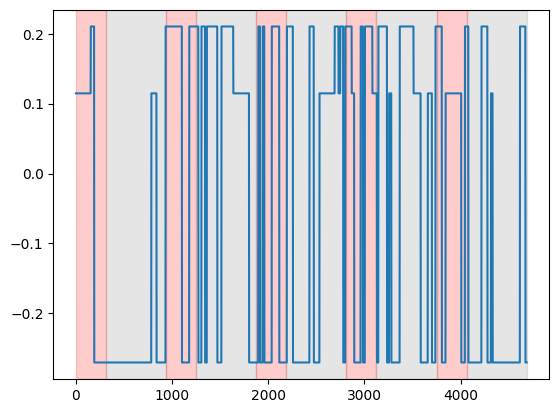

In [11]:
plot(model, preds,5)
#plt.plot(bands[0,:int(750*5/0.8)]/7)